In [1]:
#Own modules
import Pixel_Raster_class as prc
import Classification_Function as cl
import Polygons_From_Groups_Function as pol

#External modules
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Polygon, MultiPolygon

### Classification

In [2]:
# Load raster file & Initialize output filepaths
filepath = "Data/Amsterdam.tif"
output_classification_path = "Data/Amsterdam_Classified.tif"
output_grouping_path = "Data/Amsterdam_Grouped.tif"
output_geojson_path = "THE_CREATED_POLYGONS/Amsterdam_Polygon.geojson"

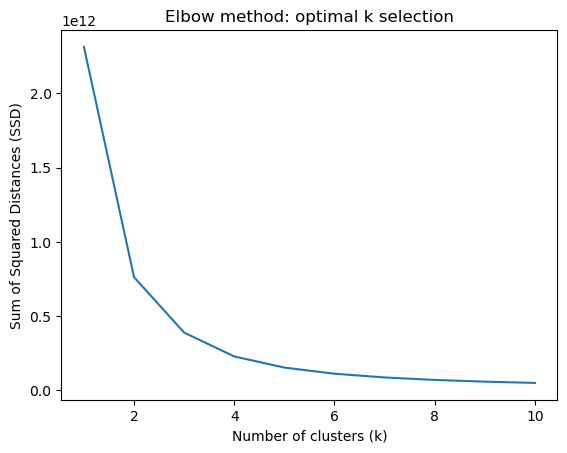

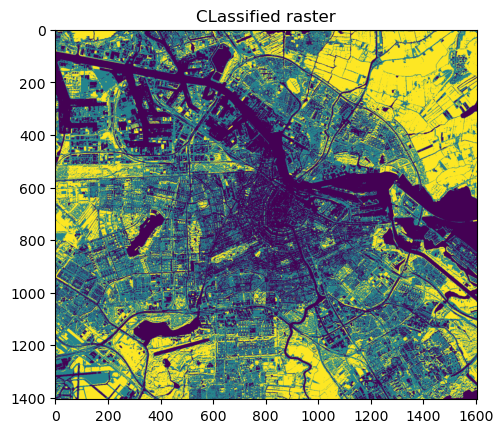

Classified raster saved.
Optimal k: 3


In [3]:
# Classify the raster using the set developed module. It can take a few minutes
max_k = 10
labels, centroids, optimal_k = cl.classify_single_band_raster(filepath, output_classification_path, max_k=max_k)
print("Optimal k:", optimal_k)

### Grouping process

In [4]:
# Read classified raster and create Pixel objects for all pixels of the band. This could take some seconds
with rasterio.open(output_classification_path) as src:
    band1 = src.read(1)
raster_lst = []
shape = band1.shape
for y, row in enumerate(band1):
    for x, elt in enumerate(row):
        pix = prc.Pixel(X=x, Y=y, Cluster_value=elt, Group=None)
        raster_lst.append(pix)

In [5]:
# Create raster object
Raster_object = prc.Raster(lst=raster_lst, shape=shape, groups=[], neighbours_diagonal=False) #If neighbours are also diagonal, this can be changed here

In [6]:
# Create groups for all clusters. It can take a few minutes
for centroid in centroids:
    print(centroid)
    Raster_object._grouping_process(centroid)
print(Raster_object.groups_per_cluster, Raster_object.n_groups, Raster_object.group_sizes[:1000])

4218.247668412021
1754.1708549027492
2861.399905710109
{np.float64(4218.247668412021): (0, 22255), np.float64(1754.1708549027492): (22256, 49300), np.float64(2861.399905710109): (49301, 76243)} 76244 [167, 2, 2, 5, 3021, 2629, 6, 11, 3, 1, 12, 1, 2, 1, 1, 1, 3, 4, 6, 13, 4, 1, 31, 1, 17, 5, 2, 34, 45, 18, 18, 7, 267, 1, 1, 59, 2, 3, 162, 25, 392, 411, 3928, 223, 1885, 4831, 12, 1, 18, 30, 4, 5, 5, 1, 1, 1, 2, 70, 4, 91, 150, 1, 1, 8, 2, 210, 5, 78244, 2, 2, 8, 31, 3, 9, 3, 46, 2, 5, 1, 192, 2, 13, 7, 24, 10, 1, 1, 1, 2, 14, 1, 2, 3, 10, 3, 6, 4, 1, 6, 1, 1, 1, 1, 1, 1, 1, 2, 2, 3, 1, 9, 4, 368, 10, 31, 3, 1, 7, 901, 1, 1, 1, 2, 7, 2, 1, 16, 2, 1, 12, 1, 1, 3, 1, 1, 11, 2, 2, 7, 4, 2, 15, 1, 4351, 1, 1, 6, 3, 1, 1, 38, 1, 1, 20, 2, 81, 2243, 67, 102, 9, 16, 3, 1, 2, 2, 2, 199, 2, 1, 1, 7, 1, 4, 3, 1, 2, 1, 2, 1, 14, 3, 3, 4, 2, 4, 1, 1, 9, 1, 3, 1, 4, 34, 7, 1, 2, 1, 1, 13, 4, 76, 6, 2, 195, 383, 7, 5, 1, 1, 1, 1, 1, 2, 1, 12, 2, 1, 8, 3, 1, 1, 2, 1, 9, 1, 15, 1, 3, 3, 21, 1, 1, 1, 24, 

In [7]:
# Check if all pixels are assigned to a group. If it prints nothing, it has been done correctly
for pixel in Raster_object.lst:
    if pixel.group is None:
        print(pixel)

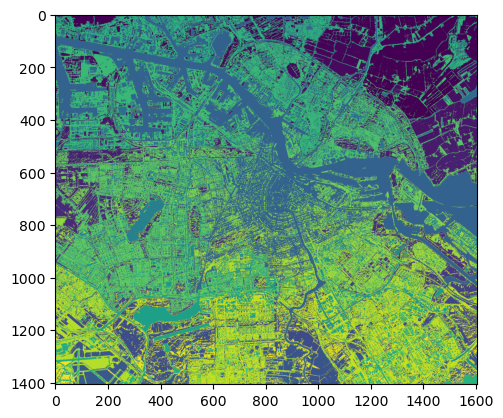

In [8]:
# Plot raster with different groups
Raster_object._output_raster(output_path=output_grouping_path, CRS=src.crs)
with rasterio.open(output_grouping_path) as Raster_grouped:
    band = Raster_grouped.read(1)
plt.imshow(band)
plt.show()

### Polygon creation

The polygon creation has only been done for a few groups. The group number can be changed.

In [9]:
TARGET_GROUP = np.argmax(Raster_object.group_sizes) #Change to desired group

In [10]:
# Create the polygon. This step might take up to a few minutes, depending on the size of the chosen group
polygon, polygon_size = pol.raster_group_to_polygon(output_grouping_path, TARGET_GROUP)
print("Polygon created")

Polygon created


<Figure size 639.282x560.718 with 0 Axes>

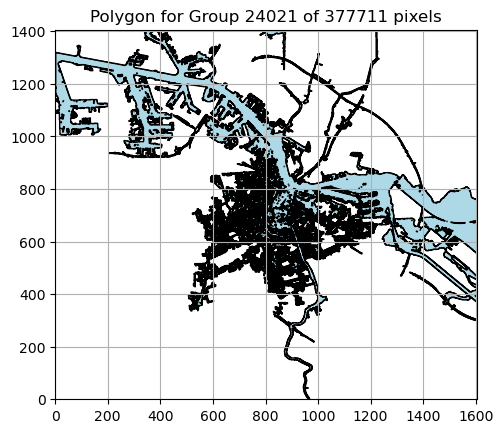

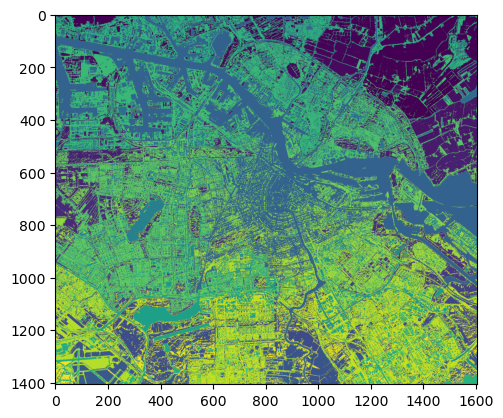

In [11]:
# Plot the polygon

# Get raster length and width
with rasterio.open(output_grouping_path) as src:
    data = src.read(1)
    y_length, x_length = src.shape

plt.figure(figsize=(12*x_length/(x_length+y_length), 12*y_length/(x_length+y_length))) # Set figure size based on raster shape

gdf = gpd.GeoDataFrame(geometry=[polygon])
gdf.plot(edgecolor="black", facecolor="lightblue")
plt.title(f"Polygon for Group {TARGET_GROUP} of {polygon_size} pixels")
plt.axis([0, x_length, 0, y_length])
plt.grid(True)
plt.show()

plt.imshow(data)
plt.show()

In [12]:
# Save the polygon as GeoJSON
pol.save_polygon_geojson(polygon, output_geojson_path, TARGET_GROUP)

GeoJSON saved
GeoJSON saved
